![Image description](./banner.png)

# Proyecto semana 3: Estrategia heurística

Esta semana se evaluarán las estrategias autónomas, en las que se definen manualmente los diversos comportamientos que el robot debe tener según su posición, el entorno y el objetivo deseado.  Es decir, estrategias reactivas que reaccionan ante los cambios en el entorno. En este caso, crearán una estrategia heurística en la que el robot deberá tomar decisiones únicamente basándose en las mediciones de los sensores. En concreto, deberán diseñar una estrategia heurística para que el robot pueda mapear su entorno y evitar los obstáculos que se le presenten por el camino. También se espera que evalúen el comportamiento de dicha estrategia mediante algunas métricas de eficiencia.


En concreto, deberán escribir un controlador, es decir, el software que determina las decisiones del robot. Tendrán que crear un algoritmo que defina las velocidades de cada una de las ruedas del robot a partir de las mediciones de los sensores del robot. De esta manera, podrán lograr mapear el entorno sin chocar contra los obstáculos que se presenten.

Tenga en cuenta que el robot ejecutará dicho controlador en cada instante de tiempo. Por lo tanto, el robot va a sensar su entorno, a partir de este sensado tomará una decisión con base en su controlador y ejecutará dicha acción. Después volverá a sensar y el proceso se repetirá. Por tanto, tenga en cuenta que debe diseñar su controlador de forma que los escenarios con los que se puede encontrar el robot se puedan resolver de manera genérica.

Como ya se indicó en las instrucciones del proyecto del curso, deberán hacer entrega de un archivo PDF en el que expliquen el razonamiento que hay detrás del diseño de su estrategia heurística y el análisis de los resultados obtenidos. Además, deberán entregar el código de la función **«update()»** dentro de la clase Controller_C que encontrarán más adelante. Con esta función evaluaremos el desempeño de su controlador en los tres ambientes que tienen a su disposición en este archivo y que iremos describiendo progresivamente, y en uno adicional que solo conocerá el equipo docente.

En este documento de Jupyter Notebook encontrarán todas las celdas de código necesarias para ejecutar el entorno de simulación y visualizar las pruebas ya escritas. No es necesario que modifiquen ninguna de ellas. La única modificación que tienen que hacer es en la función «update()» dentro de la clase Controller_C. 

Para ejecutar cada celda, pueden hacer clic en el botón «Run All» que encontrarán en la parte superior del entorno Jupyter, o también pueden ejecutar cada celda de forma independiente haciendo clic en la celda que deseen y pulsando la tecla CTRL + ENTER.


# Simulador robótico

En esta parte se encuentra todo el código necesario para ejecutar el simulador, incluido el mapeo del entorno. Gran parte de este código es el mismo que tuvieron en las dos semanas anteriores.

In [1]:
"""
Implementación simulador robotico: Esta es una versión adaptada del simulador propuesto originalmente por: Paul O'Dowd y Hemma Philamore 
https://github.com/paulodowd/GoogleColab_Simple2DSimulator
"""


from math import *
import numpy as np

import sys

import matplotlib.pyplot as plt

"""
Creación de la clase que define los obstaculos. En nuestros escenarios los obstaculos tendran forma circular.
"""

class Obstacle_c: 
  # Se asigna una posición aleatoria dentro del entorno manteniendo una distancia con el centro (donde inicia el robot)
  def __init__(self, x_prop, y_prop, arena_size=200, radius=1, rot=0.0, max_obstacles=1):

    self.radius = radius


    rot_ang = rot * ((np.pi*2)/max_obstacles)
    
    rand_dist = np.random.uniform(0.1, .7) * (arena_size/2)
    #print('arena size',arena_size/2)
    if x_prop<0 and y_prop<0:
      self.x = (arena_size/2) + rand_dist*np.cos(rot_ang)
      self.y = (arena_size/2) + rand_dist*np.sin(rot_ang)
    else:
      self.x = x_prop
      self.y = y_prop




"""
Clase que define el funcionamiento de cada sensor de proximidad.
"""
class ProxSensor_c:

  # Posición global en xy del sensor
  x = 0
  y = 0
  theta = 0

  # Para guardar la ultima lectura 
  reading = 0

  # Localizar el sensor alrededor del cuerpo del robot
  offset_dist = 0
  offset_angl = 0

  # maximo rango de lectura en cm
  max_range = 20

  
  def __init__(self, offset_dist=5, offset_angl=0):
    self.offset_dist = offset_dist
    self.offset_angl = offset_angl


  def updateGlobalPosition(self, robot_x, robot_y, robot_theta ):

    # Dirección actual del sensor es la rotación del robot
    # mas la rotación predeterminada del sensor en relación
    # al cuerpo del robot.
    self.theta = self.offset_angl + robot_theta

    sensor_x = (self.offset_dist*np.cos(self.theta))
    sensor_y = (self.offset_dist*np.sin(self.theta))

 
    self.x = sensor_x + robot_x
    self.y = sensor_y + robot_y

    self.reading = -1
  def readingAsXY(self):
    if self.reading < 0:
      return -1,-1

    else:
      x = self.x + (self.reading * np.cos(self.theta))
      y = self.y + (self.reading * np.sin(self.theta))
      return x,y

  def scanFor( self, obstruction ):

    # Escanear por posibles obstaculos
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
    distance = distance - obstruction.radius


    # Si esta fuera de rango, no retorna nada
    if distance > self.max_range:
      return

    a2o = atan2( ( obstruction.y - self.y), (obstruction.x-self.x ))

    angle_between = atan2( sin(self.theta-a2o),  cos(self.theta-a2o) )
    angle_between = abs( angle_between )

    
    if angle_between > np.pi/8:
      return

  
    if self.reading < 0:
      self.reading = distance


    if self.reading > 0:
      if distance < self.reading:
        self.reading = distance





"""
Clase que define el funcionamiento del robot
"""
class Robot_c:


  def __init__(self, x=50,y=50,theta=np.pi):
    self.x = x
    self.y = y
    self.theta = np.pi/2# theta
    self.stall = -1 # evaluar colisiones
    self.score = 0
    self.radius = 5 # 5cm radio
    self.wheel_sep = self.radius*2 # Mismo tamaño de rueda a cada lado
    self.vl = 0
    self.vr = 0

    # ubicación de los sensores en radianes
    self.sensor_dirs = [5.986479,
                        5.410521,
                        4.712389,
                        3.665191,
                        2.617994,
                        1.570796,
                        0.8726646,
                        0.296706,
                        ]

    self.prox_sensors = [] 
    for i in range(0,8):
      self.prox_sensors.append( ProxSensor_c(self.radius, self.sensor_dirs[i]) )


  def updatePosition( self, vl, vr ):

    if vl > 1.0:
      vl = 1.0
    if vl < -1.0:
      vl = -1.0
    if vr > 1.0:
      vr = 1.0
    if vr < -1.0:
      vr = -1.0

    self.vl = vl
    self.vr = vr

    self.stall = -1

    # Matriz del movimiento del robot
    r_matrix = [(vl/2)+(vr/2),0, (vr-vl)/self.wheel_sep]

    # Matriz para convertir referencia local a referencia global
    k_matrix = [
                [ np.cos(self.theta),-np.sin(self.theta),0],
                [ np.sin(self.theta), np.cos(self.theta),0],
                [0,0,1]
               ]

    result_matrix = np.matmul( k_matrix, r_matrix)

    self.x += result_matrix[0]
    self.y += result_matrix[1]
    self.theta += result_matrix[2]

    for prox_sensor in self.prox_sensors:
      prox_sensor.updateGlobalPosition( self.x, self.y, self.theta )



  
  def updateSensors(self, obstruction ):

    for prox_sensor in self.prox_sensors:
      prox_sensor.scanFor( obstruction )

  def collisionCheck(self, obstruction ):
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
    distance -= self.radius
    distance -= obstruction.radius
    if distance < 0:
      self.stall = 1
      angle = atan2( obstruction.y - self.y, obstruction.x - self.x)
      self.x += distance * np.cos(angle)
      self.y += distance * np.sin(angle)

  def updateScore(self):
    # Se define la metrica a usar para evaluar el desempeño.
    diff = np.abs(((self.vl+1) - (self.vr + 1))) * 0.5

    if diff > 0.0:
      diff =  1 - np.sqrt( diff )
    else:
      diff = 1 # - 0


    
    vel = (np.abs(self.vl) + np.abs(self.vr))/2



    new_score = vel * diff



    if self.stall == 1:
      new_score -= 3

    self.score += new_score

class Map_c:

  # init: crear arrays como rejillas de ocupación.
  # Asume una resolución igual al tamaño de la arena
  def __init__ (self, map_res):
    self.map = np.zeros((int(map_res), int(map_res)))
    self.map_res = map_res
    self.ground_truth = np.zeros((int(map_res), int(map_res)))
    self.element_count = 0

  # Comprueba si se ha almacenado algún dato en el
  # mapa.
  def hasElements(self):
    if self.element_count > 0:
      return True

    return False

  
  def getGroundTruthList(self):
    plot_elements = []
    # array is row (y), column (x)
    for y in range(0, np.size(self.ground_truth,0)):
      for x in range(0, np.size(self.ground_truth, 1)):
        if self.ground_truth[y][x] > 0:
          plot_elements.append( [x,y] )

    return np.asarray( plot_elements, dtype=float)

  
  def getMapXYList(self):
    plot_elements = []
    # array is row (y), column (x)
    for y in range(0, np.size(self.map,0)):
      for x in range(0, np.size(self.map, 1)):
        if self.map[y][x] > 0:
          plot_elements.append( [x,y] )

    return np.asarray( plot_elements, dtype=float)

  
  def addAtXY( self, x, y ):
    x = np.floor(x)
    y = np.floor(y)

    if x < 0:
      return
    if x > np.size(self.map, 1):
      return
    if y < 0:
      return
    if y > np.size(self.map, 0):
      return

    self.element_count += 1
    self.map[int(y)][int(x)] = 1

    return

  def setGroundTruth(self, obstacles ):
    for obstacle in obstacles:
      d = obstacle.radius
      while d > 0:
        a = 0.0
        while a < (np.pi*2):
          x = obstacle.x + (d*np.cos(a))
          y = obstacle.y + (d*np.sin(a))
          x = floor( x )
          y = floor( y )
          if x > 0:
            if x < self.map_res:
              if y > 0:
                if y < self.map_res:
                  self.ground_truth[int(y)][int(x)] = 1
          a += 0.1
        d = -1

  # Esta función calcula una puntuación global para el
  # mapa simplemente multiplicando el mapa por la verdad
  # verdad.  Cuando un objeto está en ambos, el resultado
  # será +1, en caso contrario +0.
  def getScore(self):
    sub = self.map * self.ground_truth
    max_score = np.count_nonzero( self.ground_truth == 1)
    so_far = np.count_nonzero(sub == 1)
    score = (so_far*2 / max_score)*100
    return score









# Creación del controlador

A continuación encontrarán la clase Controler_C. **Esta es la clase que deben modificar para diseñar su controlador.**

Como pueden observar en esta clase, solo hay una función llamada `update(self, robot):`. Dicha función recibe la información del robot. A través de la información del robot, podrán acceder a las mediciones de los sensores de distancia mediante el comando `robot.prox_sensors[i].reading`, donde i es el número del sensor, de los ocho que tiene el robot. Esto les dará un valor entre 0 y 20, dependiendo de la distancia con respecto al obstáculo, o un valor de -1 si no se está detectando ninguno. Deben tener en cuenta que su función debe devolver las velocidades de las ruedas izquierda y derecha, respectivamente. A partir de la información proporcionada por el robot, deben definir dichas velocidades, que definirán el movimiento general del robot.

En general les recomendamos que:
1. **Midan:** Lean las mediciones de los sensores 
2. **Calculen:** Analicen el comportamiento del robot para seguir mapeando el entorno
2. **Planeen:** Tomen una decición en base a la información disponible
3. **Actuen:** Retornen las velocidades de los motores apropiadas con base en su planeación

Ustedes deberán entregar **únicamente** el código que define la función `update(self, robot, objetivo):`. El equipo docente usará su función para hacer las pruebas necesarias de acuerdo con la rúbrica de calificación que encontrarán en la primera semana del curso.

Al principio, verán que la función `update(self, robot):`ya tiene algunas instrucciones definidas. Estas instrucciones tienen como objetivo mostrarles cómo interactuar con los sensores y cómo adquirir las mediciones, y también cómo pueden tomar decisiones basándose en las instrucciones if, en las que definen qué hacer cuando aparecen escenarios específicos.


In [2]:
#
# Crear código de controlador dentro de def update(self, robot):
#
# Asegúrate de devolver vl y vr al final de
# update para mover tu robot simulado.
#
class Controller_c:

  def __init__(self):
    self.state = "start" 
    self.last_state = ""
    self.sub_state = "exploring"
    self.turning = False
    
    self.sensors = {}
    self.last_sensors = {}
    self.PI = pi
    self.EPSILON = 5 # 0.05
    #self.EPSILON = 0.01 # not used
    self.ANGLE_EPSILON = 0.03 # angle tolerance for turning
    self.WALL_DETECTION_DISTANCE = 5#7 # distance to detect a front obstacle
    self.WALL_FOLLOW_DISTANCE = 4 #6 # distance to the wall to follow
    self.WALL_FOLLOW_EXTENSION = 8 #11 # distance off the wall to start turning
    self.WALL_THRESHOLD = 0.05 # margin for min and max threshold for wall following
    self.AFTER_TURN_THRESHOLD = 30 #22 # steps to wait after a turn to start following the wall again

    self.STEPS_FILTER = 15#15#4
    self.step = 0
    
    self.off_wall_offset = 0
    self.after_turn_offset = 0

  def renameSensors(self, robot):

    # Sensores Left y Right para mejorar la nomenclatura.
    sensor_dict = {"SL1":robot.prox_sensors[7].reading,
                   "SL2":robot.prox_sensors[6].reading,
                   "SL3":robot.prox_sensors[5].reading,
                   "SL4":robot.prox_sensors[4].reading,
                   "SR1":robot.prox_sensors[0].reading,
                   "SR2":robot.prox_sensors[1].reading,
                   "SR3":robot.prox_sensors[2].reading,
                   "SR4":robot.prox_sensors[3].reading}
    
    return sensor_dict
  
  def validateUTurn(self):
    # U-turn
    print("sensor diff", abs(abs(self.sensors["SR3"]) - abs(self.sensors["SR4"])))
    if (self.sensors["SR1"] == -1 and self.sensors["SR2"] == -1 and self.sensors["SR3"] == -1 and
        self.last_sensors["SR1"] == -1 and self.last_sensors["SR2"] == -1 and self.last_sensors["SR3"] == -1 ):
        # self.sensors["SR4"]*sin(self.PI/3) > self.WALL_FOLLOW_EXTENSION and 
        # self.last_sensors["SR4"]*sin(self.PI/3) > self.WALL_FOLLOW_EXTENSION):
      print("validando U-turn SR1, SR2, SR3")
      return True

    elif (self.sensors["SR1"] == -1 and self.sensors["SR2"] == -1 and self.sensors["SR3"] > 0 and self.sensors["SR4"] > 0 and 
      abs(abs(self.sensors["SR3"]) - abs(self.sensors["SR4"])) < self.EPSILON and self.state == "WALL_FOLLOWING" and  
      self.sensors["SR3"] > self.WALL_FOLLOW_EXTENSION ):
      
      
      print("validando corner turn SR3 only")
      if self.off_wall_offset < self.STEPS_FILTER - 6:
        print("overwriting off_wall_offset")
        self.off_wall_offset = self.STEPS_FILTER - 4
      self.sub_state = "outer_corner"

      return True
    # elif (self.sensors["SR1"] == -1 and self.sensors["SR2"] == -1 and self.sensors["SR3"] > self.WALL_FOLLOW_EXTENSION and
    #       self.last_sensors["SR1"] == -1 and self.last_sensors["SR2"] == -1 and self.last_sensors["SR3"] > self.WALL_FOLLOW_EXTENSION and
    #       self.sensors["SR4"] == -1 and 
    #       self.last_sensors["SR4"] == -1 and self.state == "WALL_FOLLOWING"):
    #   print("validando U-turn SR3 only")
    #   return True    
    return False
  
  def normalizeAngle(self, angle):
    if angle > pi:
            angle -= 2 * pi
    elif angle < -pi:
        angle += 2 * pi
    return angle
  
  def checkReadyForTurn(self):
    print("offset_counter", self.off_wall_offset)
    if (self.sensors["SR1"] == -1 and self.sensors["SR2"] == -1 and #self.sensors["SR3"] == -1 and
      self.last_sensors["SR1"] == -1 and self.last_sensors["SR2"] == -1  ):#self.last_sensors["SR3"] == -1 and
      
      self.off_wall_offset += 1

    if self.off_wall_offset > self.STEPS_FILTER:
      self.off_wall_offset = 0
      print("starting turn", self.after_turn_offset)
      self.after_turn_offset = 0
      return True
    return False



  def update(self, robot):

    vl = 0
    vr = 0
    #
    # Actualizo last states
    ### ----------------------------------------------  READ SENSORS AND LAST STATES ---------------------------------------------- ###

    self.last_state = self.state
    self.last_sensors = self.sensors
    current_angle = self.normalizeAngle(robot.theta)
    self.sensors = self.renameSensors(robot)
    self.step += 1

    ### ---------------------------------------------- STATES AND SUBSTATES DEFINITIONS ---------------------------------------------- ###

    right_side_free = (self.sensors["SR1"] == -1 and self.sensors["SR2"] == -1 and self.sensors["SR3"] == -1)
    left_side_full = (self.sensors["SL1"] > 0 and self.sensors["SL2"] > 0 and self.sensors["SL3"] > 0)
    front_obstacle = -1 < self.sensors["SL1"] <= self.WALL_DETECTION_DISTANCE and -1 < self.sensors["SR1"] <= self.WALL_DETECTION_DISTANCE
    
    ### ------------------------- FREE FORWARD
    if all(value == -1 for value in self.sensors.values()) and self.turning == False and self.sub_state != "after_turn":
        self.state = "FREE_FORWARD"

    ### ------------------------- FREE FORWARD ----- exploring
    elif right_side_free and self.state == "start" and left_side_full :
        self.state = "ROTATE_OBSTACLE_90_POSITIVE"
        target_angle = round((current_angle + pi/2) / (pi/2)) * (pi/2)
        self.target_angle = self.normalizeAngle(target_angle)
        self.turning = True
        self.sub_state = "maze_turn"

    ### ------------------------- STOP ----- obstacle detected
    elif (front_obstacle and self.turning == False and self.turning == False and
          (self.last_state == "FREE_FORWARD" or self.last_state=="ROTATE_OBSTACLE_90_POSITIVE")): # este creo que puede ser eliminado
        self.state = "STOP"
        self.sub_state = "obstacle_detected"

    ### ------------------------- ROTATE OBSTACLE 90 POSITIVE
    elif (-1 < self.sensors["SL1"] <= self.WALL_DETECTION_DISTANCE and -1 < self.sensors["SR1"] <= self.WALL_DETECTION_DISTANCE and
          self.last_state == "STOP" and self.turning == False):
        
        self.state = "ROTATE_OBSTACLE_90_POSITIVE"
        target_angle = round((current_angle + pi/2) / (pi/2)) * (pi/2)
        self.target_angle = self.normalizeAngle(target_angle)
        self.turning = True

    ### ------------------------- WALL FOLLOWING
    elif (self.last_state == "ROTATE_OBSTACLE_90_POSITIVE" and 
        self.sensors["SR3"] > -1 and self.turning == False):
       
       self.state = "WALL_FOLLOWING"
    
    
    elif self.last_state == "WALL_FOLLOWING" or self.last_state == "FREE_FORWARD":
      # el robot deja de seguir la pared y se encuentra vacio
      
      ### ------------------------- ROTATE OBSTACLE 90 NEGATIVE ---- corner_turn
      if (self.turning == False and self.validateUTurn() == True and
          self.checkReadyForTurn() == True and self.after_turn_offset == 0):
        
        self.state = "ROTATE_OBSTACLE_90_NEGATIVE"
        target_angle = round((current_angle - pi/2) / (pi/2)) * (pi/2)
        self.target_angle = self.normalizeAngle(target_angle)
        self.turning = True
        self.sub_state = "corner_turn"

      ### ------------------------- ROTATE OBSTACLE 90 POSITIVE ---- corner_turn (inner corner)
      if (self.turning == False and self.sub_state != "outer_corner" and
          -1 < self.sensors["SL1"] <= self.WALL_DETECTION_DISTANCE and -1 < self.sensors["SR1"] <= self.WALL_DETECTION_DISTANCE):
        
        self.state = "ROTATE_OBSTACLE_90_POSITIVE"
        target_angle = round((current_angle + pi/2) / (pi/2)) * (pi/2)
        self.target_angle = self.normalizeAngle(target_angle)
        self.turning = True
        self.sub_state = "corner_turn"

      ### ------------------------- ROTATE OBSTACLE 90 NEGATIVE ---- corner_turn (outer corner, inside maze)
      if (self.turning == False and self.sub_state == "outer_corner" and
          -1 < self.sensors["SL1"] <= self.WALL_DETECTION_DISTANCE and -1 < self.sensors["SR1"] <= self.WALL_DETECTION_DISTANCE):
        print("forcing outer corner turn")
        self.state = "ROTATE_OBSTACLE_90_NEGATIVE"
        target_angle = round((current_angle - pi/2) / (pi/2)) * (pi/2)
        self.target_angle = self.normalizeAngle(target_angle)
        self.turning = True
        self.sub_state = "corner_turn"

    ### ------------------------- WALL FOLLOWING ---- after_turn
    elif (self.last_state == "ROTATE_OBSTACLE_90_NEGATIVE" and self.sub_state in ["corner_turn"] and
        self.turning == False):
      self.state = "WALL_FOLLOWING"
      self.sub_state = "after_turn"


    ### ---------------------------------------------- ACTUATORS VALUE UPDATE ---------------------------------------------- ###

    if self.state == "FREE_FORWARD":
      vl = 0.8
      vr = 0.8

    elif self.state == "WALL_FOLLOWING":
      # WALL FOLLOWING CORRECTIONs

      print("wall following values", self.sensors["SR3"], self.WALL_FOLLOW_DISTANCE - self.WALL_THRESHOLD, self.WALL_FOLLOW_DISTANCE + self.WALL_THRESHOLD)
      
      right_correction = (0 < self.sensors["SR3"] < (self.WALL_FOLLOW_DISTANCE - self.WALL_THRESHOLD) or 
         0 < self.sensors["SR2"]*cos(self.PI/4) < (self.WALL_FOLLOW_DISTANCE - self.WALL_THRESHOLD))
        #  0 < self.sensors["SR4"]*cos(self.PI/3) < (self.WALL_FOLLOW_DISTANCE - self.WALL_THRESHOLD))
      
      left_correction = (0 < self.sensors["SR3"] > (self.WALL_FOLLOW_DISTANCE + self.WALL_THRESHOLD) or
        0 < self.sensors["SR2"]*cos(self.PI/4) > (self.WALL_FOLLOW_DISTANCE + self.WALL_THRESHOLD) ) 
        # 0 < self.sensors["SR4"]*cos(self.PI/3) > (self.WALL_FOLLOW_DISTANCE + self.WALL_THRESHOLD))

      left_correction = (0 < self.sensors["SR3"] > (self.WALL_FOLLOW_DISTANCE + self.WALL_THRESHOLD) or
        0 < self.sensors["SR2"]*cos(self.PI/4) > (self.WALL_FOLLOW_DISTANCE + self.WALL_THRESHOLD) ) 
        # 0 < self.sensors["SR4"]*cos(self.PI/3) > (self.WALL_FOLLOW_DISTANCE + self.WALL_THRESHOLD))

      if self.sensors["SR3"] == -1 or self.sub_state == "after_turn":
        vl = 0.4
        vr = 0.4
        if self.sub_state == "after_turn":
          self.after_turn_offset += 1
          vl = 0.6 #73
          vr = 0.6 #73
          print("after_turn_offset", self.after_turn_offset)

        if self.after_turn_offset > self.AFTER_TURN_THRESHOLD:
          print("resetting after_turn_offset")
          self.after_turn_offset = 0
          if self.sensors["SR2"] == -1:
            print("second turn")
            self.state = "ROTATE_OBSTACLE_90_NEGATIVE"
            target_angle = round((current_angle - pi/2) / (pi/2)) * (pi/2)
            self.target_angle = self.normalizeAngle(target_angle)
            self.turning = True
            self.sub_state = "corner_turn"
          else:
            print("wall found")
            self.state = "WALL_FOLLOWING"
            self.sub_state = "exploring"

      elif self.sub_state == "outer_corner":
        vl = 0.45
        vr = 0.4


      elif right_correction:
        self.sub_state = "R_correcting"
        vl = 0.4 #0.3
        vr = 0.54 #0.4
      elif left_correction:
        self.sub_state = "L_correcting"
        vl = 0.54 #0.4
        vr = 0.4 #0.3
      else:
        self.sub_state = "exploring"
        vl = 0.7
        vr = 0.7

    elif self.state == "STOP":
      vl = 0.0
      vr = 0.0

    elif self.state == "ROTATE_OBSTACLE_90_POSITIVE":
      
      angle_diff = abs(self.normalizeAngle(current_angle - self.target_angle))
      print("angle_diff", angle_diff)
      print("target_angle", self.target_angle)
      print("current_angle", current_angle)
      if angle_diff > self.ANGLE_EPSILON:
        self.turning = True
        vl = -0.2
        vr = 0.2
        
      else:
        self.turning = False
        vl = 0.0
        vr = 0.0

    elif self.state == "ROTATE_OBSTACLE_90_NEGATIVE":
      angle_diff = abs(self.normalizeAngle(current_angle - self.target_angle))
      print("angle_diff", angle_diff)
      print("target_angle", self.target_angle)
      print("current_angle", current_angle)
      if angle_diff > self.ANGLE_EPSILON:
        self.turning = True
        vl = 0.15
        vr = -0.15
        
      else:
        self.turning = False
        vl = 0.0
        vr = 0.0
     

    current_x = robot.x
    current_y = robot.y
    current_theta = robot.theta


    print(self.step," - Posición actual: ", current_x, current_y, current_theta, self.state, self.sub_state, vl, vr)


    return vl, vr



# Evaluación

Como ya se les indicó, el éxito de su controlador dependerá del desempeño en cuatro escenarios específicos. A continuación se presentan tres de ellos; el último se mantiene oculto.

En cada escenario, el desempeño de su robot dependerá del éxito del controlador que definieron para mapear efectivamente el entorno. Esto se analiza mediante una métrica (score) con la que ya han interactuado, el porcentaje total mapeado, entre mayor sea este porcentage mejor el comportamiento del robot.

Como sabrá, cada escenario aportará el 4 % de los 30 % totales que vale esta entrega del proyecto. La calificación de cada escenario será de $score*4/100$. Por tanto, para obtener un valor del 4 %, deben lograr que el robot mapee el ambiente de la forma más completa posible.

Por cada escenario dispondrán de dos códigos: el primero les permitirá visualizar gráficamente su comportamiento y el segundo solamente simula internamente el robot. La simulación puede llevar mucho tiempo en ejecutarse debido a la animación gráfica. Por esta razón, se les presenta un segundo código que simula el comportamiento del robot sin mostrar la animación de su comportamiento. Así, al final, podrán visualizar la evolución de la métrica de eficiencia, lo que les permitirá hacer simulaciones más rápido y probar sus controladores. Cuando encuentren que la métrica de eficiencia ha aumentado, podrán hacer la visualización de la animación. Tambien pueden modificar el parametro `numframes` para disminuir el tiempo de simulación. Esto puede ser útil para observar el comportamiento del robot por un breve periodo de tiempo, analizando si esta haciendo lo que esperan.

**Es importante señalar que deberá entregar un único controlador capaz de resolver todos los escenarios, NO uno por escenario.**



# Primer escenario

En el primer escenario existe únicamente un obstaculo en el centro de la arena. El robot debe dirigirse inicialmente en linea recta hasta encontrarse con sicho obstaculo y mapearlo.



**RECOMENDACIÓN:** Tenga en cuenta que para detectar el obstáculo, el robot deberá recorrer TODO el espacio que lo rodea, asegurándose de que está lo suficientemente cerca para detectarlo, pero lo suficientemente lejos para evitar una colisión.


## Visualización gráfica

In [ ]:




import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from random import shuffle, randrange
%matplotlib inline

from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

def hacer_reja():
    inicio = 50
    fin = 150
    ubicaciones = []
    for i in range(inicio,fin):
        ubicaciones.append([i, 100])
    return ubicaciones



ub_obstacles = hacer_reja()
num_obstacles = len(ub_obstacles)


numframes = 1000
arena_width = 200.0
obstacle_radius = 1.25
num_sensors = 8

my_robot = Robot_c(100,60,np.random.random()*np.pi*2)

map = Map_c( arena_width)


fig = plt.figure(figsize=(8,4), dpi=120)
ax = plt.subplot(1,2,1, aspect='equal', autoscale_on=False, xlim=(0, arena_width), ylim=(0, arena_width))
map_ax = plt.subplot(1,2,2, aspect='equal', autoscale_on=False, xlim=(0, arena_width), ylim=(0, arena_width))

gui_robot, = ax.plot([], [], 'bo', ms=my_robot.radius*2)
gui_robot.set_data([], [])
gui_dir, = ax.plot([], [], 'r-', c="yellow")
gui_sensor = ax.plot( *[[],[]]*num_sensors,'r-', c="red")
gui_obstacles, = ax.plot([],[],'bo', ms=obstacle_radius*2, c="orange")
gui_map_truth, = map_ax.plot([],[],'s', ms=1, c="whitesmoke")
gui_map, = map_ax.plot([],[],'s', ms=1, c="black")



obstacles = []
obstacles_xy = []
for i in range( num_obstacles ):
  obstacles.append( Obstacle_c( ub_obstacles[i][0], ub_obstacles[i][1], arena_width, obstacle_radius, i, num_obstacles) )
  obstacles_xy.append( [obstacles[i].x, obstacles[i].y] )

obstacles_xy = np.asarray( obstacles_xy, dtype=float)
gui_obstacles.set_data( obstacles_xy[:,0], obstacles_xy[:,1]  )

map.setGroundTruth( obstacles )
ground_truth_xy = map.getGroundTruthList()
gui_map_truth.set_data( ground_truth_xy[:,0], ground_truth_xy[:,1]  )

my_controller = Controller_c()


def animate(i):

    global ax, map_ax, fig


    vl, vr = my_controller.update( my_robot )

    my_robot.updatePosition(vl, vr)
    for obstacle in obstacles:
      my_robot.collisionCheck( obstacle )
      my_robot.updateSensors( obstacle )

    for prox in my_robot.prox_sensors:
      x,y = prox.readingAsXY()
      map.addAtXY(x,y)

    gui_robot.set_data([my_robot.x], [my_robot.y])
    if my_robot.stall == 1:
      gui_robot.set_color("red")
    else:
      gui_robot.set_color("blue")


    tx = my_robot.x + (my_robot.radius*1.4*np.cos(my_robot.theta))
    ty = my_robot.y + (my_robot.radius*1.4*np.sin(my_robot.theta))
    gui_dir.set_data( (my_robot.x,tx), (my_robot.y, ty) )

    for i in range(0, len(my_robot.prox_sensors)):
      prox_sensor = my_robot.prox_sensors[i]

      ox = prox_sensor.x
      oy = prox_sensor.y
      if prox_sensor.reading > 0:
        tx = prox_sensor.x + prox_sensor.reading * np.cos( prox_sensor.theta)
        ty = prox_sensor.y + prox_sensor.reading * np.sin( prox_sensor.theta)
      else:
        tx = prox_sensor.x + np.cos( prox_sensor.theta)
        ty = prox_sensor.y + np.sin( prox_sensor.theta)

      gui_sensor[i].set_data( (ox,tx), (oy, ty) )


    my_robot.updateScore()
    #ax.set_title('Score: {0:f}% mapped'.format( map.getScore() ))
    # MODIFIED AX TITLE
    ax.set_title('Score: {0:f}% mapped - step {1}'.format( map.getScore(), my_controller.step ))

    if map.hasElements() == True:
      map_elements = map.getMapXYList()
      gui_map.set_data( map_elements[:,0], map_elements[:,1] )


    return gui_robot,

plt.close()
ani = animation.FuncAnimation(fig, animate, frames=numframes, interval=10, blit=True)
ani


## Ejecución rápida

1  - Posición actual:  100 60 1.5707963267948966 start exploring 0 0
2  - Posición actual:  100.0 60.0 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
3  - Posición actual:  100.0 60.8 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
4  - Posición actual:  100.0 61.599999999999994 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
5  - Posición actual:  100.0 62.39999999999999 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
6  - Posición actual:  100.0 63.19999999999999 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
7  - Posición actual:  100.0 63.999999999999986 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
8  - Posición actual:  100.0 64.79999999999998 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
9  - Posición actual:  100.0 65.59999999999998 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
10  - Posición actual:  100.0 66.39999999999998 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
11  - Posición actual:  100.0 67.19999999999997 1.5707963267948966 FREE_FORWARD e

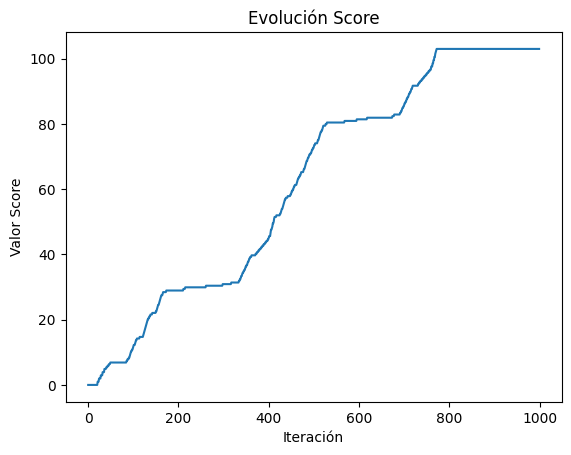

In [3]:

def hacer_reja():
    inicio = 50
    fin = 150
    ubicaciones = []
    for i in range(inicio,fin):
        ubicaciones.append([i, 100])
    return ubicaciones



ub_obstacles = hacer_reja()
num_obstacles = len(ub_obstacles)


numframes = 1000
arena_width = 200.0
obstacle_radius = 1.25
num_sensors = 8

my_robot = Robot_c(100,60,np.random.random()*np.pi*2)

map = Map_c( arena_width)



obstacles = []
obstacles_xy = []
for i in range( num_obstacles ):
  obstacles.append( Obstacle_c( ub_obstacles[i][0], ub_obstacles[i][1], arena_width, obstacle_radius, i, num_obstacles) )
  obstacles_xy.append( [obstacles[i].x, obstacles[i].y] )


map.setGroundTruth( obstacles )
ground_truth_xy = map.getGroundTruthList()


my_controller = Controller_c()



def actualizar():

    

    vl, vr = my_controller.update( my_robot )

    my_robot.updatePosition(vl, vr)
    for obstacle in obstacles:
      my_robot.collisionCheck( obstacle )
      my_robot.updateSensors( obstacle )

    for prox in my_robot.prox_sensors:
      x,y = prox.readingAsXY()
      map.addAtXY(x,y)

    
    my_robot.updateScore()



    return map.getScore()

evolucion_score = []
for i in range(numframes):
   score_temporal = actualizar()
   evolucion_score.append(score_temporal)

plt.plot(evolucion_score)
plt.title('Evolución Score')
plt.ylabel('Valor Score')
plt.xlabel('Iteración')

print("Valor final del score: ", evolucion_score[-1])

#plt.show()

# Segundo escenario

En este escenario se simula que el robot se encuentra dentro de una habitación con una entrada. El objetivo es que el robot pueda detectar adecuadamente la ubicación de las paredes, tanto en el interior como en el exterior de la habitación, para poder estimar el ancho del muro.

## Visualización gráfica.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from random import shuffle, randrange
%matplotlib inline

# To produce our animated simulation output
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128



def hacer_reja():
    inicio = 50
    fin = 150
    ubicaciones = []
    for i in range(inicio,fin):
        ubicaciones.append([inicio,i])
        ubicaciones.append([fin,i])
        ubicaciones.append([i,fin])
        if i> inicio+50:
            ubicaciones.append([i, inicio])
    return ubicaciones



ub_obstacles = hacer_reja()
num_obstacles = len(ub_obstacles)


numframes = 2200 #2200
arena_width = 200.0
obstacle_radius = 1.25
num_sensors = 8

my_robot = Robot_c(100,100,np.random.random()*np.pi*2)

map = Map_c( arena_width)


fig = plt.figure(figsize=(8,4), dpi=120)
ax = plt.subplot(1,2,1, aspect='equal', autoscale_on=False, xlim=(0, arena_width), ylim=(0, arena_width))
map_ax = plt.subplot(1,2,2, aspect='equal', autoscale_on=False, xlim=(0, arena_width), ylim=(0, arena_width))

gui_robot, = ax.plot([], [], 'bo', ms=my_robot.radius*2)
gui_robot.set_data([], [])
gui_dir, = ax.plot([], [], 'r-', c="yellow")
gui_sensor = ax.plot( *[[],[]]*num_sensors,'r-', c="red")
gui_obstacles, = ax.plot([],[],'bo', ms=obstacle_radius*2, c="orange")
gui_map_truth, = map_ax.plot([],[],'s', ms=1, c="whitesmoke")
gui_map, = map_ax.plot([],[],'s', ms=1, c="black")


obstacles = []
obstacles_xy = []
for i in range( num_obstacles ):
  obstacles.append( Obstacle_c( ub_obstacles[i][0], ub_obstacles[i][1], arena_width, obstacle_radius, i, num_obstacles) )
  obstacles_xy.append( [obstacles[i].x, obstacles[i].y] )

obstacles_xy = np.asarray( obstacles_xy, dtype=float)
gui_obstacles.set_data( obstacles_xy[:,0], obstacles_xy[:,1]  )

map.setGroundTruth( obstacles )
ground_truth_xy = map.getGroundTruthList()
gui_map_truth.set_data( ground_truth_xy[:,0], ground_truth_xy[:,1]  )


my_controller = Controller_c()


def animate(i):

    global ax, map_ax, fig


    vl, vr = my_controller.update( my_robot )

    my_robot.updatePosition(vl, vr)
    for obstacle in obstacles:
      my_robot.collisionCheck( obstacle )
      my_robot.updateSensors( obstacle )

    for prox in my_robot.prox_sensors:
      x,y = prox.readingAsXY()
      map.addAtXY(x,y)


    gui_robot.set_data([my_robot.x], [my_robot.y])
    if my_robot.stall == 1:
      gui_robot.set_color("red")
    else:
      gui_robot.set_color("blue")

    tx = my_robot.x + (my_robot.radius*1.4*np.cos(my_robot.theta))
    ty = my_robot.y + (my_robot.radius*1.4*np.sin(my_robot.theta))
    gui_dir.set_data( (my_robot.x,tx), (my_robot.y, ty) )


    for i in range(0, len(my_robot.prox_sensors)):
      prox_sensor = my_robot.prox_sensors[i]

      ox = prox_sensor.x
      oy = prox_sensor.y
      if prox_sensor.reading > 0:
        tx = prox_sensor.x + prox_sensor.reading * np.cos( prox_sensor.theta)
        ty = prox_sensor.y + prox_sensor.reading * np.sin( prox_sensor.theta)
      else:
        tx = prox_sensor.x + np.cos( prox_sensor.theta)
        ty = prox_sensor.y + np.sin( prox_sensor.theta)

      gui_sensor[i].set_data( (ox,tx), (oy, ty) )

    my_robot.updateScore()
    # ax.set_title('Score: {0:f}% mapped'.format( map.getScore() ))
    ax.set_title('Score: {0:f}% mapped - step {1}'.format( map.getScore(), my_controller.step ))

    if map.hasElements() == True:
      map_elements = map.getMapXYList()
      gui_map.set_data( map_elements[:,0], map_elements[:,1] )


    return gui_robot,

plt.close()
ani = animation.FuncAnimation(fig, animate, frames=numframes, interval=10, blit=True)
ani


#plt.show()

## Ejecución rápida

1  - Posición actual:  100 100 1.5707963267948966 start exploring 0 0
2  - Posición actual:  100.0 100.0 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
3  - Posición actual:  100.0 100.8 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
4  - Posición actual:  100.0 101.6 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
5  - Posición actual:  100.0 102.39999999999999 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
6  - Posición actual:  100.0 103.19999999999999 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
7  - Posición actual:  100.0 103.99999999999999 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
8  - Posición actual:  100.0 104.79999999999998 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
9  - Posición actual:  100.0 105.59999999999998 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
10  - Posición actual:  100.0 106.39999999999998 1.5707963267948966 FREE_FORWARD exploring 0.8 0.8
11  - Posición actual:  100.0 107.19999999999997 1.5707963267948966 FREE_FORWARD explo

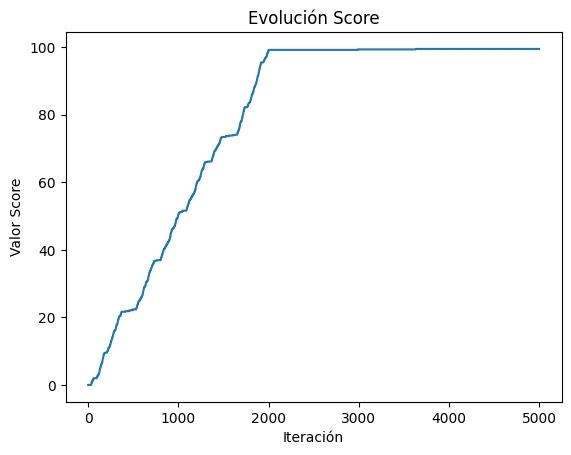

In [4]:



def hacer_reja():
    inicio = 50
    fin = 150
    ubicaciones = []
    for i in range(inicio,fin):
        ubicaciones.append([inicio,i])
        ubicaciones.append([fin,i])
        ubicaciones.append([i,fin])
        if i> inicio+50:
            ubicaciones.append([i, inicio])
    return ubicaciones



ub_obstacles = hacer_reja()
num_obstacles = len(ub_obstacles)


numframes = 5000
arena_width = 200.0
obstacle_radius = 1.25
num_sensors = 8

my_robot = Robot_c(100,100,np.random.random()*np.pi*2)

map = Map_c( arena_width)


obstacles = []
obstacles_xy = []
for i in range( num_obstacles ):
  obstacles.append( Obstacle_c( ub_obstacles[i][0], ub_obstacles[i][1], arena_width, obstacle_radius, i, num_obstacles) )
  obstacles_xy.append( [obstacles[i].x, obstacles[i].y] )



map.setGroundTruth( obstacles )
ground_truth_xy = map.getGroundTruthList()



# ¡Una instancia de nuestro controlador!
my_controller = Controller_c()


def actualizar():

    vl, vr = my_controller.update( my_robot )

    my_robot.updatePosition(vl, vr)
    for obstacle in obstacles:
      my_robot.collisionCheck( obstacle )
      my_robot.updateSensors( obstacle )

    for prox in my_robot.prox_sensors:
      x,y = prox.readingAsXY()
      map.addAtXY(x,y)

    
    my_robot.updateScore()



    return map.getScore()

evolucion_score = []
for i in range(numframes):
   score_temporal = actualizar()
   evolucion_score.append(score_temporal)

plt.plot(evolucion_score)
plt.title('Evolución Score')
plt.ylabel('Valor Score')
plt.xlabel('Iteración')

print("Valor final del score: ", evolucion_score[-1])


# Tercer escenario

En el tercer escenario el robot se encuentra dentro de un laberinto. Su objetivo es que el robot pueda detectar adecuadamente todas las paredes del mismo. Este escenario simula lo que puede encontrarse dentro de una casa con muchas habitaciones y pasillos.


## Visualización gráfica

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from random import shuffle, randrange
from random import random, seed
%matplotlib inline

from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
# seed(13) # 42 ok



def make_maze(w = 5, h = 5):
    vis = [[0] * w + [1] for _ in range(h)] + [[1] * (w + 1)]
    ver = [["|  "] * w + ['|'] for _ in range(h)] + [[]]
    hor = [["+--"] * w + ['+'] for _ in range(h + 1)]

    def walk(x, y):
        vis[y][x] = 1

        d = [(x - 1, y), (x, y + 1), (x + 1, y), (x, y - 1)]
        shuffle(d)
        for (xx, yy) in d:
            if vis[yy][xx]: continue
            if xx == x: hor[max(y, yy)][x] = "+  "
            if yy == y: ver[y][max(x, xx)] = "   "
            walk(xx, yy)

    walk(randrange(w), randrange(h))
    diferencia = 40
    coo_y = [200,160,120,80,40,0]
    coor_obs = []
    sep = 2.5
    for i in range(len(hor)):
        act_x = 0
        act_y = coo_y[i]
        for j in range(len(hor[i])):
            if hor[i][j] == '+--':
                for s in range(int(diferencia/sep)):
                    coor_obs.append([act_x+(s+1)*sep , act_y])
            act_x += diferencia
    for i in range(len(ver)):
        act_x = 0
        act_y = coo_y[i]
        for j in range(len(ver[i])):
            if "|" in ver[i][j] :
                for s in range(int(diferencia/sep)):
                    coor_obs.append([act_x , act_y-(s+1)*sep])
            act_x += diferencia
    return coor_obs
ub_obstacles = make_maze()
num_obstacles = len(ub_obstacles)



numframes = 6#6000
arena_width = 200.0
obstacle_radius = 1.25
num_sensors = 8

my_robot = Robot_c(10,10,np.random.random()*np.pi*2)

map = Map_c( arena_width)


fig = plt.figure(figsize=(8,4), dpi=120)
ax = plt.subplot(1,2,1, aspect='equal', autoscale_on=False, xlim=(0, arena_width), ylim=(0, arena_width))
map_ax = plt.subplot(1,2,2, aspect='equal', autoscale_on=False, xlim=(0, arena_width), ylim=(0, arena_width))

gui_robot, = ax.plot([], [], 'bo', ms=my_robot.radius*2)
gui_robot.set_data([], [])
gui_dir, = ax.plot([], [], 'r-', c="yellow")
gui_sensor = ax.plot( *[[],[]]*num_sensors,'r-', c="red")
gui_obstacles, = ax.plot([],[],'bo', ms=obstacle_radius*2, c="orange")
gui_map_truth, = map_ax.plot([],[],'s', ms=1, c="whitesmoke")
gui_map, = map_ax.plot([],[],'s', ms=1, c="black")



# Una lista de obstáculos dentro del espacio
obstacles = []
obstacles_xy = []
for i in range( num_obstacles ):
  obstacles.append( Obstacle_c( ub_obstacles[i][0], ub_obstacles[i][1], arena_width, obstacle_radius, i, num_obstacles) )
  obstacles_xy.append( [obstacles[i].x, obstacles[i].y] )

obstacles_xy = np.asarray( obstacles_xy, dtype=float)
gui_obstacles.set_data( obstacles_xy[:,0], obstacles_xy[:,1]  )

map.setGroundTruth( obstacles )
ground_truth_xy = map.getGroundTruthList()
gui_map_truth.set_data( ground_truth_xy[:,0], ground_truth_xy[:,1]  )


# ¡Una instancia de nuestro controlador!
my_controller = Controller_c()


def animate(i):

    global ax, map_ax, fig


    vl, vr = my_controller.update( my_robot )

    my_robot.updatePosition(vl, vr)
    for obstacle in obstacles:
      my_robot.collisionCheck( obstacle )
      my_robot.updateSensors( obstacle )

    for prox in my_robot.prox_sensors:
      x,y = prox.readingAsXY()
      map.addAtXY(x,y)

    gui_robot.set_data([my_robot.x], [my_robot.y])
    if my_robot.stall == 1:
      gui_robot.set_color("red")
    else:
      gui_robot.set_color("blue")

    tx = my_robot.x + (my_robot.radius*1.4*np.cos(my_robot.theta))
    ty = my_robot.y + (my_robot.radius*1.4*np.sin(my_robot.theta))
    gui_dir.set_data( (my_robot.x,tx), (my_robot.y, ty) )

    for i in range(0, len(my_robot.prox_sensors)):
      prox_sensor = my_robot.prox_sensors[i]

      ox = prox_sensor.x
      oy = prox_sensor.y
      if prox_sensor.reading > 0:
        tx = prox_sensor.x + prox_sensor.reading * np.cos( prox_sensor.theta)
        ty = prox_sensor.y + prox_sensor.reading * np.sin( prox_sensor.theta)
      else:
        tx = prox_sensor.x + np.cos( prox_sensor.theta)
        ty = prox_sensor.y + np.sin( prox_sensor.theta)

      gui_sensor[i].set_data( (ox,tx), (oy, ty) )

    my_robot.updateScore()
    # ax.set_title('Score: {0:f}% mapped'.format( map.getScore() ))
    ax.set_title('Score: {0:f}% mapped - step {1}'.format( map.getScore(), my_controller.step ))

    if map.hasElements() == True:
      map_elements = map.getMapXYList()
      gui_map.set_data( map_elements[:,0], map_elements[:,1] )


    return gui_robot,

plt.close()
ani = animation.FuncAnimation(fig, animate, frames=numframes, interval=10, blit=True)
ani



## Ejecución rápida

1  - Posición actual:  10 10 1.5707963267948966 start exploring 0 0
angle_diff 1.5707963267948966
target_angle 3.141592653589793
current_angle 1.5707963267948966
2  - Posición actual:  10.0 10.0 1.5707963267948966 ROTATE_OBSTACLE_90_POSITIVE maze_turn -0.2 0.2
angle_diff 1.5307963267948965
target_angle 3.141592653589793
current_angle 1.6107963267948966
3  - Posición actual:  10.0 10.0 1.6107963267948966 ROTATE_OBSTACLE_90_POSITIVE maze_turn -0.2 0.2
angle_diff 1.4907963267948965
target_angle 3.141592653589793
current_angle 1.6507963267948966
4  - Posición actual:  10.0 10.0 1.6507963267948966 ROTATE_OBSTACLE_90_POSITIVE maze_turn -0.2 0.2
angle_diff 1.4507963267948965
target_angle 3.141592653589793
current_angle 1.6907963267948967
5  - Posición actual:  10.0 10.0 1.6907963267948967 ROTATE_OBSTACLE_90_POSITIVE maze_turn -0.2 0.2
angle_diff 1.4107963267948964
target_angle 3.141592653589793
current_angle 1.7307963267948967
6  - Posición actual:  10.0 10.0 1.7307963267948967 ROTATE_OBSTACL

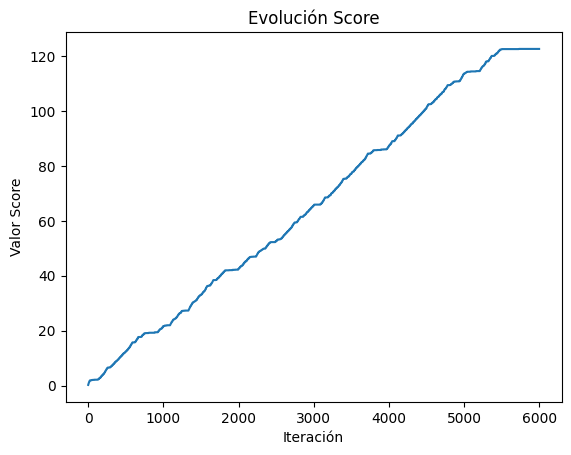

In [9]:

from random import random, seed
# seed(7) # 42 ok, 123 ok, 23 ok, 19 ok, 10, 7

def make_maze(w = 5, h = 5):
    vis = [[0] * w + [1] for _ in range(h)] + [[1] * (w + 1)]
    ver = [["|  "] * w + ['|'] for _ in range(h)] + [[]]
    hor = [["+--"] * w + ['+'] for _ in range(h + 1)]

    def walk(x, y):
        vis[y][x] = 1

        d = [(x - 1, y), (x, y + 1), (x + 1, y), (x, y - 1)]
        shuffle(d)
        for (xx, yy) in d:
            if vis[yy][xx]: continue
            if xx == x: hor[max(y, yy)][x] = "+  "
            if yy == y: ver[y][max(x, xx)] = "   "
            walk(xx, yy)

    walk(randrange(w), randrange(h))
    diferencia = 40
    coo_y = [200,160,120,80,40,0]
    coor_obs = []
    sep = 2.5
    for i in range(len(hor)):
        act_x = 0
        act_y = coo_y[i]
        for j in range(len(hor[i])):
            if hor[i][j] == '+--':
                for s in range(int(diferencia/sep)):
                    coor_obs.append([act_x+(s+1)*sep , act_y])
            act_x += diferencia
    for i in range(len(ver)):
        act_x = 0
        act_y = coo_y[i]
        for j in range(len(ver[i])):
            if "|" in ver[i][j] :
                for s in range(int(diferencia/sep)):
                    coor_obs.append([act_x , act_y-(s+1)*sep])
            act_x += diferencia
    return coor_obs
ub_obstacles = make_maze()
num_obstacles = len(ub_obstacles)

numframes = 6000
arena_width = 200.0
obstacle_radius = 1.25
num_sensors = 8
my_robot = Robot_c(10,10,np.random.random()*np.pi*2)

map = Map_c( arena_width)


obstacles = []
obstacles_xy = []
for i in range( num_obstacles ):
  obstacles.append( Obstacle_c( ub_obstacles[i][0], ub_obstacles[i][1], arena_width, obstacle_radius, i, num_obstacles) )
  obstacles_xy.append( [obstacles[i].x, obstacles[i].y] )


map.setGroundTruth( obstacles )
ground_truth_xy = map.getGroundTruthList()



my_controller = Controller_c()


evolucion_score = []
for i in range(numframes):
   score_temporal = actualizar()
   evolucion_score.append(score_temporal)

plt.plot(evolucion_score)
plt.title('Evolución Score')
plt.ylabel('Valor Score')
plt.xlabel('Iteración')

print("Valor final del score: ", evolucion_score[-1])


# Entrega final

Finalmente, recuerde que debe entregar un PDF con la explicación del diseño de la estrategia heurística y el análisis de los resultados obtenidos, donde analice los siguientes aspectos:
Resultados, presente conclusiones sobre el desempeño del modelo, detecte fallos en el controlador utilizado y proponga posibles mejoras. Además, debe responder a las siguientes preguntas:

* Indique qué aprendizajes obtuvo al resolver el problema de teleoperación de las semanas 2 y 3 del curso que ha podido aplicar directamente en este proyecto.
* ¿Qué otra métrica de eficiencia se podría haber usado? ¿En qué habría cambiado su algoritmo?
* Si en el tercer escenario se hubiera añadido el objetivo de llegar a un punto específico del laberinto, ¿en qué habría cambiado su algoritmo? 

## **Por favor revisar el archivo entrega_1.md para ver las respuestas de estas preguntas.**
